In [1]:
from nst_setup import *
cnn.summary()  # Prints summary of the layers and weights of the pre-trained VGG19 model

C:\Users\arulson\Anaconda3_2019\envs\tensorflow1.14_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\arulson\Anaconda3_2019\envs\tensorflow1.14_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\arulson\Anaconda3_2019\envs\tensorflow1.14_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\arul

C:\Users\arulson\Anaconda3_2019\envs\tensorflow1.14_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\arulson\Anaconda3_2019\envs\tensorflow1.14_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\arulson\Anaconda3_2019\envs\tensorflow1.14_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500, 500, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 125, 125, 128)     0         
_____

In [2]:
raw_content_image = Image.open("challenge/japanese_garden.jpg")
raw_style_image = Image.open("challenge/picasso_selfportrait.jpg")

# Reshape and subtract mean RGB values, so that the images may be fed into the CNN
content, resized_raw_content = setup_image(raw_content_image)
style, resized_raw_style = setup_image(raw_style_image)

# Save the re-sized content and style images, for reference
Image.fromarray(resized_raw_content[0]).save("Generated_Images/CONTENT.jpg")
Image.fromarray(resized_raw_style[0]).save("Generated_Images/STYLE.jpg")

In [3]:
tf.reset_default_graph()
# Build a graph to compute the representations of the given content and style images, by feeding
# them into the network
a_C = tf_cnn(content, 'content')
A_S = tf_cnn(style, 'style')
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    # Get the np.arrays that remain fixed throughout the optimization process
    a_C_val = sess.run(a_C)
    A_S_val = sess.run(A_S)  

In [4]:
def content_cost(a_C_generated, a_C_val):
    """Inputs: Generated Content representation tensor, corresponding np.arrays for content image
        Output: Content cost tensor"""
    assert a_C_generated.shape == a_C_val.shape
    _, ny, nx, c = a_C_val.shape
    d = a_C_generated - a_C_val
    return tf.pow(tf.norm(d), 2)/(4*ny*nx*c)

def style_cost(A_S_generated, A_S_val, coeffs=[0.2]*5):
    """Inputs: List of Content representation tensors of style image, corresponding np.arrays for
    style image, list of 5 "weights"
    Output: Style cost tensor through a weighted sum of contributions of 5 CONV layers"""
    J_style = 0
    for i in range(len(A_S_generated)):
        J_style += coeffs[i]*single_layer_style_cost(A_S_generated[i], A_S_val[i])
    return J_style

def single_layer_style_cost(a_S_generated, a_S_val):
    """Inputs: Content representation tensor of style image, corresponding np.array for style image
    Output: Style cost tensor"""
    assert a_S_generated.shape == a_S_val.shape
    _, ny, nx, c = a_S_val.shape
    
    a_S_generated_vec = tf.reshape(a_S_generated, [ny*nx, c])
    a_S_val_vec = tf.reshape(a_S_val, [ny*nx, c])
    # Compute the gram matrices:
    g_S_generated = tf.matmul(tf.transpose(a_S_generated_vec), a_S_generated_vec)
    g_S_val = tf.matmul(tf.transpose(a_S_val_vec), a_S_val_vec)
    
    d = g_S_generated - g_S_val
    J_single_style = tf.pow(tf.norm(d), 2)/(2*ny*nx*c)**2
    
    return J_single_style

def total_cost(J_content, J_style, a=10, b=40):
    """Outputs the total cost tensor. The ratio a/b governs how much emphasis is to be placed on the
    content image or style image"""
    return a*J_content + b*J_style    

In [5]:
tf.reset_default_graph()
# Build the graph for Neural Style Transfer
generated = tf.Variable(content, trainable=True)
representations = tf_cnn(generated, 'generate')  # This is a dictionary of 2 tensors

a_C_generated = representations["content_layer"]
A_S_generated = representations["style_layers"]

J_content = content_cost(a_C_generated, a_C_val)
J_style = style_cost(A_S_generated, A_S_val)
J = total_cost(J_content, J_style)
# Optimizer object to minimize the total cost. Here, Adam has been used with a learning rate of 2
optimizer = tf.train.AdamOptimizer(2.0).minimize(J)
init = tf.global_variables_initializer()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Iteration 1: Done
Iteration 2: Done
Iteration 3: Done
Iteration 4: Done
Iteration 5: Done
Iteration 6: Done
Iteration 7: Done
Iteration 8: Done
Iteration 9: Done
Iteration 10:
Total Cost = 1257776151.1485503
Content Cost = 9729.15050410931
Style Cost = 31441971.49108773
Image Saved
Iteration 10: Done
Iteration 11: Done
Iteration 12: Done
Iteration 13: Done
Iteration 14: Done
Iteration 15: Done
Iteration 16: Done
Iteration 17: Done
Iteration 18: Done
Iteration 19: Done
Iteration 20:
Total Cost = 572393791.1209956
Content Cost = 13087.370584754233
Style Cost = 14306572.935378704
Image Saved
Iteration 20: Done
Iteration 21: Done
Iteration 22: Done
Iteration 23: Done
Iteration 24: Done
Iteration 25: Done
Iteration 26: Done
Iteration 27: Done
Iteration 28: Done
Iteration 29: Done
Iteration 30:
Total Cost = 328773003.663179
Content Cost = 14577.59664646997
Style Cost = 8215680.692417856
Image Saved
Iteration 30: Done
Iteration 31: Done
Iteration 32: Done
Iteration 33: Done
Iteration 34: Done

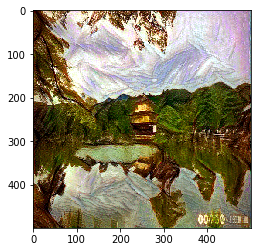

In [6]:
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(1, num_iterations+1):
        sess.run(optimizer)
        generated_image = sess.run(generated) # (1 X 500 X 500 X 3) np.array
        
        # Print the total cost and save the intermediate generated image after every 10 iterations
        # to keep track of training progress
        if i % 10 == 0:
            J_t, J_c, J_s = sess.run([J, J_content, J_style])
            print("Iteration {}:\nTotal Cost = {}\nContent Cost = {}\nStyle Cost = {}".format(i, J_t, J_c, J_s))
            G = presentable(generated_image) # (500 X 500 X 3) image that can be saved and viewed
            Image.fromarray(G).save("Generated_Images/iter"+str(i)+".jpg")
            print("Image Saved")
        print("Iteration "+str(i)+": Done")
    # Display the final image within the notebook
    plt.imshow(G)              

In [ ]:
# Scroll down in the previous cell's output to see the final generated image